## Chapter 10

### Fairness and Bias Mitigation

##### We will look at the explanations in understanding bias and mitigations

This notebook focusses on fairlearn. We use a Decision Tree model for the classification.

We will use the transformer-interpret library here

https://github.com/cdpierse/transformers-interpret

We are using the sklearn diabetes datasets. More details on the dataset can be found here <br>
 https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

|**age**|age in years|
|-------|------------|
|**sex**|gender|
|**bmi**|body mass index|
|**bp** | average blood pressure |
| **s1** | tc, total serum cholesterol |
| **s2**  | ldl, low-density lipoproteins |
| **s3**  | hdl, high-density lipoproteins |
| **s4** | tch, total cholesterol / HDL |
| **s5** | ltg, possibly log of serum triglycerides level |
| **s6** | glu, blood sugar level |

In [2]:
!pip install fairlearn

   ---------------------------------------- 0.0/232.3 kB ? eta -:--:--
   ----- ---------------------------------- 30.7/232.3 kB 1.3 MB/s eta 0:00:01
   --------------------- ------------------ 122.9/232.3 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 232.3/232.3 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   - -------------------------------------- 0.4/11.6 MB 13.2 MB/s eta 0:00:01
   ------ --------------------------------- 2.0/11.6 MB 24.9 MB/s eta 0:00:01
   -------------- ------------------------- 4.3/11.6 MB 34.0 MB/s eta 0:00:01
   ---------------- ----------------------- 4.9/11.6 MB 34.6 MB/s eta 0:00:01
   ---------------- ----------------------- 4.9/11.6 MB 34.6 MB/s eta 0:00:01
   ------------------------- -------------- 7.5/11.6 MB 28.2 MB/s eta 0:00:01
   ------------------------- -------------- 7.5/11.6 MB 28.2 MB/s eta 0:00:01
   -------------------------- ------------- 7.7/11.6 MB 22.5 MB/s eta 0:00

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dice-ml 0.11 requires pandas<2.0.0, but you have pandas 2.2.3 which is incompatible.


In [30]:
from fairlearn.datasets import fetch_diabetes_hospital
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Fetch the dataset
data = fetch_diabetes_hospital(as_frame=True)

# Extract features and target
X = data['data'].copy()
y = data['target']

X.drop(columns=["readmitted"], inplace=True)
y = data.target
X_frame = pd.get_dummies(X)
race_values = X['race']
print(race_values.value_counts())

X_frame = pd.get_dummies(X)


race
Caucasian          76099
AfricanAmerican    19210
Unknown             2273
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64


In [19]:
# Split the data into training and testing sets
import numpy as np

X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X_frame, y, race_values, random_state=123)

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
#y_pred = clf.predict(X_test)
y_pred = (clf.predict_proba(X_test)[:,1] >= 0.1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6475119880512539


In [20]:
from fairlearn.metrics import MetricFrame

mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=A_test)
print(mf.overall.item())

mf.by_group

0.6475119880512539


race
AfricanAmerican    0.653649
Asian              0.784431
Caucasian          0.639443
Hispanic           0.667319
Other              0.692958
Unknown            0.772881
Name: accuracy_score, dtype: float64

In [27]:
from fairlearn.metrics import false_negative_rate, false_positive_rate, selection_rate, count

mf = MetricFrame(metrics=false_positive_rate, y_true=y_test, y_pred=y_pred, sensitive_features=A_test)
print(mf.overall.item())

mf.by_group

0.39662111361726593


race
AfricanAmerican    0.389325
Asian              0.235294
Caucasian          0.406423
Hispanic           0.370370
Other              0.344937
Unknown            0.248148
Name: false_positive_rate, dtype: float64

array([[<Axes: title={'center': 'accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race'>,
        <Axes: title={'center': 'false negative rate'}, xlabel='race'>],
       [<Axes: title={'center': 'selection rate'}, xlabel='race'>,
        <Axes: title={'center': 'count'}, xlabel='race'>,
        <Axes: xlabel='race'>],
       [<Axes: xlabel='race'>, <Axes: xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

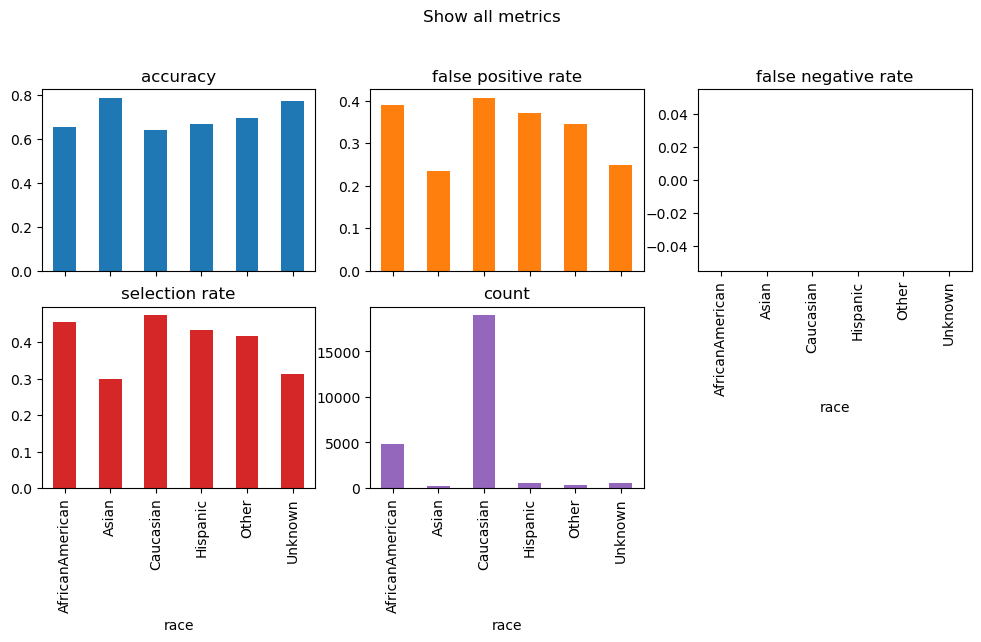

In [22]:
metrics = {
    "accuracy": accuracy_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=A_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)


In [23]:
from fairlearn.reductions import ErrorRate, EqualizedOdds, ExponentiatedGradient
objective = ErrorRate(costs={'fp': 0.1, 'fn': 0.9})
constraint = EqualizedOdds(difference_bound=0.01)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint, objective=objective)
mitigator.fit(X_train, y_train, sensitive_features=A_train)
y_pred_mitigated = mitigator.predict(X_test)
mf_mitigated = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=A_test)
print(mf_mitigated.overall.item())

mf_mitigated.by_group


0.6428739878940335


race
AfricanAmerican    0.653649
Asian              0.682635
Caucasian          0.639443
Hispanic           0.636008
Other              0.645070
Unknown            0.657627
Name: accuracy_score, dtype: float64

In [28]:
from fairlearn.metrics import MetricFrame

mf = MetricFrame(metrics=false_positive_rate, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=A_test)
print(mf.overall.item())

mf.by_group


0.40183981248065104


race
AfricanAmerican    0.389325
Asian              0.346405
Caucasian          0.406423
Hispanic           0.405229
Other              0.398734
Unknown            0.374074
Name: false_positive_rate, dtype: float64

array([[<Axes: title={'center': 'accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race'>,
        <Axes: title={'center': 'false negative rate'}, xlabel='race'>],
       [<Axes: title={'center': 'selection rate'}, xlabel='race'>,
        <Axes: title={'center': 'count'}, xlabel='race'>,
        <Axes: xlabel='race'>],
       [<Axes: xlabel='race'>, <Axes: xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

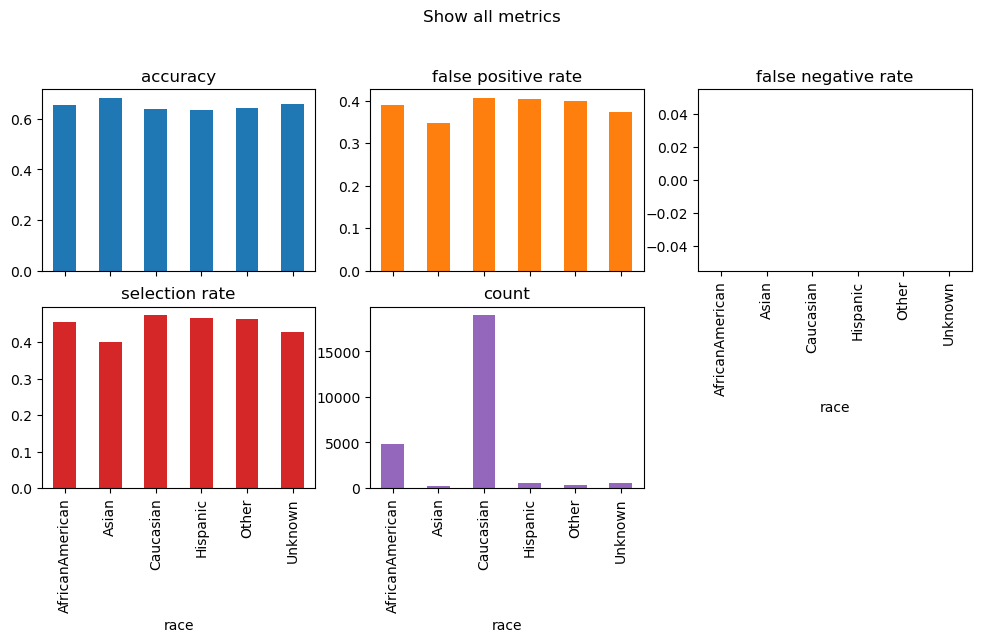

In [26]:

metrics = {
    "accuracy": accuracy_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=A_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)
